In [ ]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(os.listdir('/content/drive/MyDrive/ndvi-color'))

['red', 'yellow', 'green', 'prediksi']


In [ ]:
# Define root directory
root_dir = '/content/drive/MyDrive/land-class-ndvi-color'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_test_dirs(root_path):
  

  if os.path.isdir(root_path):
    pass
  else:
    os.makedirs(root_path)

  train_path = os.path.join(root_path, "training")
  test_path = os.path.join(root_path, "testing")

  if os.path.isdir(train_path) and os.path.isdir(test_path):
    pass
  else:
    os.makedirs(os.path.join(root_path, "training")) 
    os.makedirs(os.path.join(root_path, "testing")) 
  
  if os.path.isdir(os.path.join(train_path, "2")) and os.path.isdir(os.path.join(train_path, "3")) and os.path.isdir(os.path.join(train_path, "4")):
    pass
  else:
    os.makedirs(os.path.join(train_path, "2")) 
    os.makedirs(os.path.join(train_path, "3")) 
    os.makedirs(os.path.join(train_path, "4"))

  if os.path.isdir(os.path.join(test_path, "2")) and os.path.isdir(os.path.join(test_path, "3")) and os.path.isdir(os.path.join(test_path, "4")):
    pass
  else:
    os.makedirs(os.path.join(test_path, "2")) 
    os.makedirs(os.path.join(test_path, "3")) 
    os.makedirs(os.path.join(test_path, "4")) 

  
try:
  create_train_test_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [ ]:

# for rootdir, dirs, files in os.walk(root_dir):
#     for subdir in dirs:
#         print(os.path.join(rootdir, subdir))

In [ ]:
# \split_data
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

  files = []

  for filename in os.listdir(SOURCE):
    file_path = SOURCE + filename

    if os.path.getsize(file_path):
      files.append(filename)
    else:
      print('{} is zero length, so ignoring'.format(filename))
  
  n_files = len(files)
  split_point = int(n_files * SPLIT_SIZE)

  randoms = random.sample(files, n_files)

  train_set = randoms[:split_point]
  test_set = randoms[split_point:]

  for filename in train_set:
    copyfile(SOURCE + filename, TRAINING + filename)
  for filename in test_set:
    copyfile(SOURCE + filename, TESTING + filename)

In [ ]:
# Test your split_data function

# Define paths
C2_SOURCE_DIR = "/content/drive/MyDrive/ndvi-color/red/"
C3_SOURCE_DIR = "/content/drive/MyDrive/ndvi-color/green/"
C4_SOURCE_DIR = "/content/drive/MyDrive/ndvi-color/yellow/"

TRAINING_DIR = "/content/drive/MyDrive/land-class-ndvi-color/training/"
TESTING_DIR = "/content/drive/MyDrive/land-class-ndvi-color/testing/"

TRAINING_C2_DIR = os.path.join(TRAINING_DIR, "2/")
TESTING_C2_DIR = os.path.join(TESTING_DIR, "2/")

TRAINING_C3_DIR = os.path.join(TRAINING_DIR, "3/")
TESTING_C3_DIR = os.path.join(TESTING_DIR, "3/")

TRAINING_C4_DIR = os.path.join(TRAINING_DIR, "4/")
TESTING_C4_DIR = os.path.join(TESTING_DIR, "4/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_C2_DIR)) > 0:
  for file in os.scandir(TRAINING_C2_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_C3_DIR)) > 0:
  for file in os.scandir(TRAINING_C3_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_C4_DIR)) > 0:
  for file in os.scandir(TRAINING_C4_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_C2_DIR)) > 0:
  for file in os.scandir(TESTING_C2_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_C3_DIR)) > 0:
  for file in os.scandir(TESTING_C3_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_C4_DIR)) > 0:
  for file in os.scandir(TESTING_C4_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .8

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(C2_SOURCE_DIR, TRAINING_C2_DIR, TESTING_C2_DIR, split_size)
split_data(C3_SOURCE_DIR, TRAINING_C3_DIR, TESTING_C3_DIR, split_size)
split_data(C4_SOURCE_DIR, TRAINING_C4_DIR, TESTING_C4_DIR, split_size)

# Check that the number of images matches the expected output
print(f"\n\nThere are {len(os.listdir(TRAINING_C2_DIR))} images of C2 for training")
print(f"There are {len(os.listdir(TRAINING_C3_DIR))} images of C3 for training")
print(f"There are {len(os.listdir(TRAINING_C4_DIR))} images of C4 for training")
print(f"There are {len(os.listdir(TESTING_C2_DIR))} images of C2 for testing")
print(f"There are {len(os.listdir(TESTING_C3_DIR))} images of C3 for testing")
print(f"There are {len(os.listdir(TESTING_C4_DIR))} images of C4 for testing")



There are 88 images of C2 for training
There are 140 images of C3 for training
There are 9 images of C4 for training
There are 23 images of C2 for testing
There are 35 images of C3 for testing
There are 3 images of C4 for testing


In [ ]:
# \train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):


  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(50, 50))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(50, 50))
 
  return train_generator, validation_generator


In [ ]:

# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)

Found 237 images belonging to 3 classes.
Found 61 images belonging to 3 classes.


In [ ]:

def create_model():


  model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 50x50 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(50, 50, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu', name='features'),
    tf.keras.layers.Dense(3, activation='softmax')
])
  
  model.compile(optimizer=RMSprop(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']) 
    


  return model


In [ ]:
# Get the untrained model
model = create_model()

# Train the model
# Note that this may take some time.
history = model.fit(train_generator, epochs=30, steps_per_epoch=8, validation_data = validation_generator, verbose = 1, validation_steps=1)

Epoch 1/30
8/8 [==============================] - 12s 111ms/step - loss: 0.6657 - accuracy: 0.7426 - val_loss: 0.2198 - val_accuracy: 0.9688
Epoch 2/30
8/8 [==============================] - 1s 93ms/step - loss: 0.3073 - accuracy: 0.8903 - val_loss: 0.3502 - val_accuracy: 0.9062
Epoch 3/30
8/8 [==============================] - 1s 86ms/step - loss: 0.1981 - accuracy: 0.9283 - val_loss: 0.2146 - val_accuracy: 0.9375
Epoch 4/30
8/8 [==============================] - 1s 85ms/step - loss: 0.2035 - accuracy: 0.9241 - val_loss: 0.2589 - val_accuracy: 0.9062
Epoch 5/30
8/8 [==============================] - 1s 86ms/step - loss: 0.1515 - accuracy: 0.9494 - val_loss: 0.2221 - val_accuracy: 0.9375
Epoch 6/30
8/8 [==============================] - 1s 88ms/step - loss: 0.1836 - accuracy: 0.9325 - val_loss: 0.1931 - val_accuracy: 0.9062
Epoch 7/30
8/8 [==============================] - 1s 84ms/step - loss: 0.1809 - accuracy: 0.9409 - val_loss: 0.1279 - val_accuracy: 0.9688
Epoch 8/30
8/8 [=========

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1936)              0         
                                                                 
 dropout (Dropout)           (None, 1936)              0

## Display Feature Maps

(1, 48, 48, 16)
(1, 24, 24, 16)
(1, 22, 22, 16)
(1, 11, 11, 16)
(1, 1936)
(1, 1936)
(1, 512)
(1, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


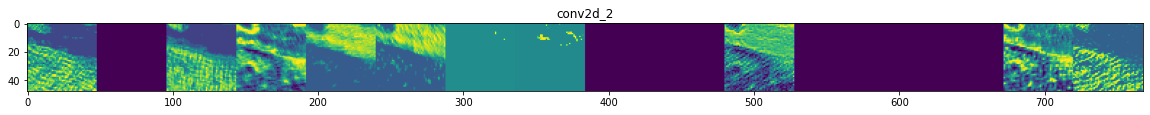

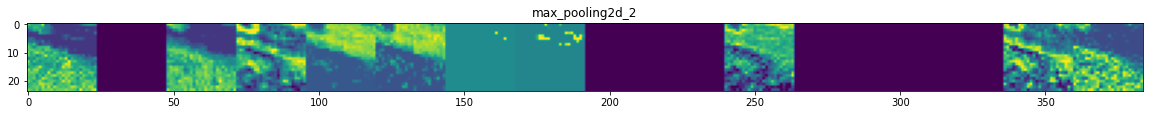

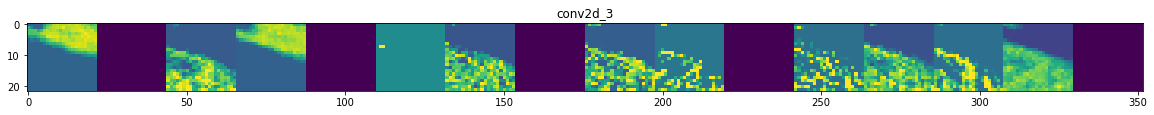

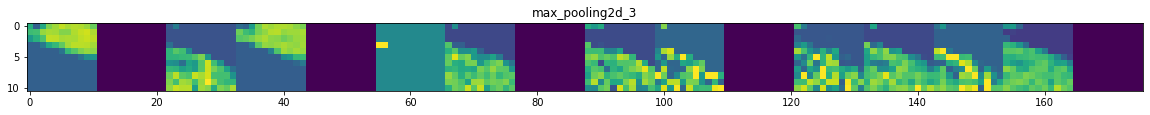

In [ ]:

img_path='/content/drive/MyDrive/land-class-ndvi-color/testing/2/ndvi_2_02.png' #dog
# Define a new Model, Input= image 
# Output= intermediate representations for all layers in the  
# previous model after the first.
successive_outputs = [layer.output for layer in model.layers[0:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
#Load the input image
img = load_img(img_path, target_size=(50, 50))
# Convert ht image to Array of dimension (150,150,3)
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)
# Rescale by 1/255
x /= 255.0
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

(1, 48, 48, 16)
(1, 24, 24, 16)
(1, 22, 22, 16)
(1, 11, 11, 16)
(1, 1936)
(1, 1936)
(1, 512)
(1, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


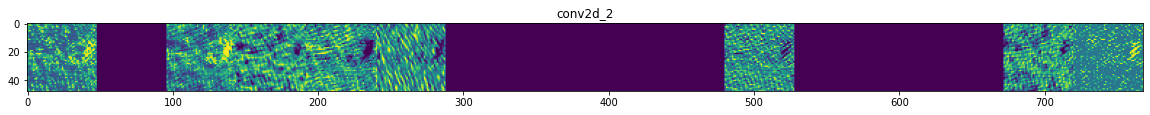

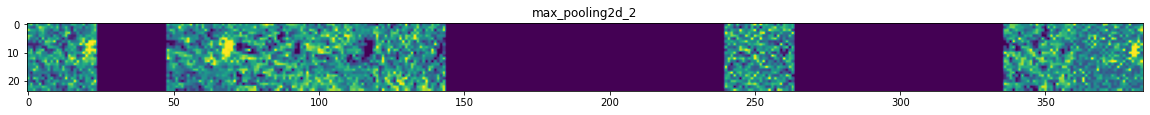

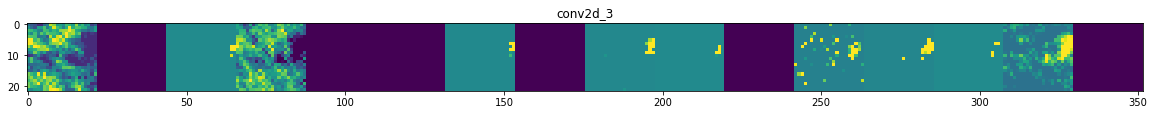

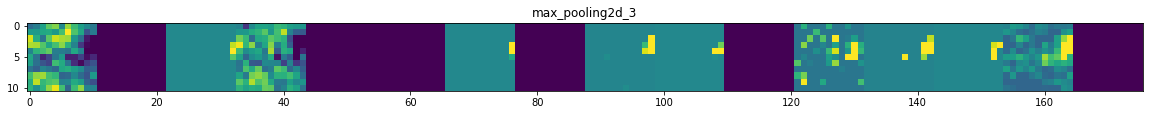

In [ ]:
img_path='/content/drive/MyDrive/land-class-ndvi-color/testing/3/ndvi_1_21.png' #dog
# Define a new Model, Input= image 
# Output= intermediate representations for all layers in the  
# previous model after the first.
successive_outputs = [layer.output for layer in model.layers[0:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
#Load the input image
img = load_img(img_path, target_size=(50, 50))
# Convert ht image to Array of dimension (150,150,3)
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)
# Rescale by 1/255
x /= 255.0
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

(1, 48, 48, 16)
(1, 24, 24, 16)
(1, 22, 22, 16)
(1, 11, 11, 16)
(1, 1936)
(1, 1936)
(1, 512)
(1, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


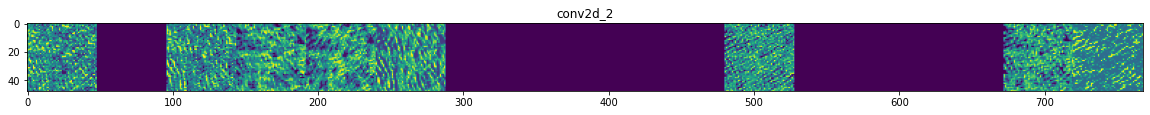

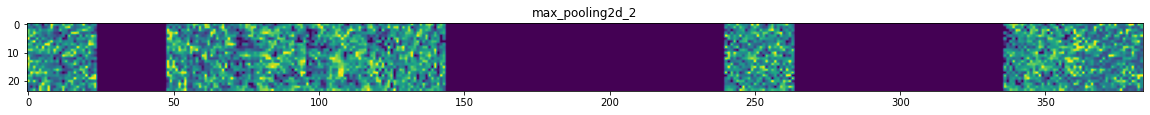

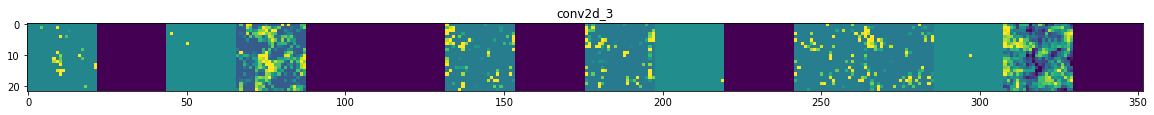

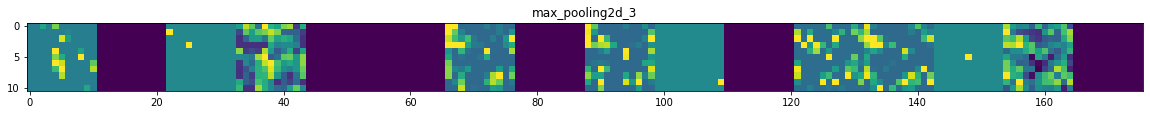

In [ ]:
img_path='/content/drive/MyDrive/land-class-ndvi-color/testing/4/ndvi_1_16.png' #dog
# Define a new Model, Input= image 
# Output= intermediate representations for all layers in the  
# previous model after the first.
successive_outputs = [layer.output for layer in model.layers[0:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
#Load the input image
img = load_img(img_path, target_size=(50, 50))
# Convert ht image to Array of dimension (150,150,3)
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)
# Rescale by 1/255
x /= 255.0
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

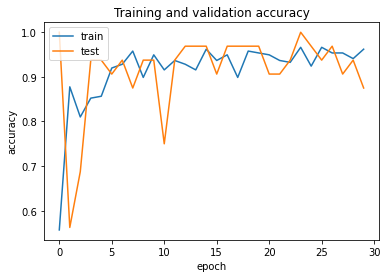

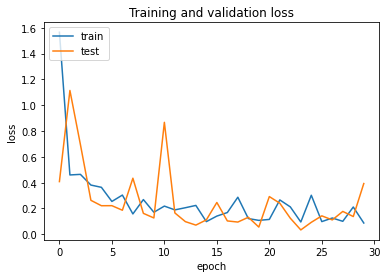

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
# plt.plot(epochs, acc, 'r', "Training Accuracy")
# plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training and validation accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

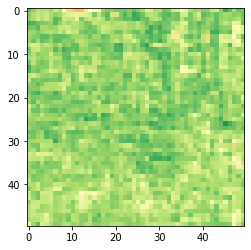

/content/drive/MyDrive/ndvi-color/prediksi/ndvi_green.png
[Red, Green, Yellow]
[[3.3346598e-07 9.9996376e-01 3.5886809e-05]]


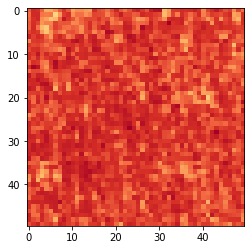

/content/drive/MyDrive/ndvi-color/prediksi/ndvi_red.png
[Red, Green, Yellow]
[[1.0000000e+00 1.1046449e-18 1.0633460e-11]]


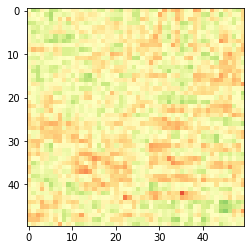

/content/drive/MyDrive/ndvi-color/prediksi/ndvi_yellow.png
[Red, Green, Yellow]
[[0.50784045 0.12228633 0.3698732 ]]


In [ ]:
import numpy as np
from keras.preprocessing import image

uploaded = ['/content/drive/MyDrive/ndvi-color/prediksi/ndvi_green.png', '/content/drive/MyDrive/ndvi-color/prediksi/ndvi_red.png', '/content/drive/MyDrive/ndvi-color/prediksi/ndvi_yellow.png']

for fn in uploaded:
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(50, 50))
  x = image.img_to_array(img)
  x /= 255.
  x = np.expand_dims(x, axis=0)
  

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  plt.imshow(img)
  plt.show()
  print(fn)
  print('[Red, Green, Yellow]')
  print(classes)